In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
from ggmodel_dev.graphmodel import GraphModel, concatenate_graph_specs
from ggmodel_dev.validation import score_model, plot_diagnostic, score_model_dictionnary

from data_utils.database import select_dataset
from data_utils.utils import get_X_y_from_data, data_dict_from_df_tables

import pandas as pd
import numpy as np

# Data

In [121]:
def prepare_vehicle_data():

    df_tables = ['vehicleownership']
    
    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    
    #df_dictionnary['vehicleownership'] = df_dictionnary['vehicleownership'].astype({'Year': int})
    
    data_dict = data_dict_from_df_tables([df[['ISO', 'Year', 'Value', 'Variable']] for _, df in df_dictionnary.items()])

    
    
    def process_series_0(series_name, series):
        s = series.reset_index(level='Year').dropna().astype({'Year': int}).set_index('Year', append=True)[series_name]
        return s
    
    def process_series_1(series_name, series):
        s = series.dropna().droplevel(level='Year')
        return s
    
    data_dict_0 = {k: process_series_0(k, v) for k, v in data_dict.items() if k not in ['MAX_sat', 'VEHC_mid', 'VEHC_rate']}
    data_dict_1 = {k: process_series_1(k, v) for k, v in data_dict.items() if k in ['MAX_sat', 'VEHC_mid', 'VEHC_rate']}

    data_dict = {}
    data_dict.update(data_dict_0)
    data_dict.update(data_dict_1)
    
    return data_dict

data_dict = prepare_vehicle_data()

In [171]:
data_dict['VEHC_rate']

ISO
ARG    0.000068
AUT    0.000057
BEL    0.000052
DEU    0.000068
FRA    0.000054
JPN    0.000046
KOR    0.000047
UZB    0.000021
Name: VEHC_rate, dtype: float64

# Model

In [154]:
graph_specifications = {
    'VEHC': {'type': 'output',
             'unit': 'vehicles per 1000 capita',
             'name': 'Vehicle ownership rate',
             'computation': lambda MAX_sat, VEHC_mid, VEHC_rate, GDPC, **kwargs:  MAX_sat * np.exp (-VEHC_mid * np.exp (-VEHC_rate * GDPC))
             },
    'MAX_sat': {'type': 'parameter', # Name to be changed ! 
              'unit': 'vehicles per 1000 capita',
              'name': 'max saturation level',
              },
    'VEHC_mid': {'type': 'parameter',
              'unit': '1',
              'name': 'Vehicle ownership halfway point'},

    'VEHC_rate': {'type': 'parameter',
             'unit': 'capita / constant 2010 US dollar',
             'name': 'Vehicle ownership growth rate'},

    'GDPC': {'type': 'input',
             'unit': 'constant 2010 US dollars per capita',
             'name': 'gross domestic product per capita'}
}

model = GraphModel(graph_specifications)

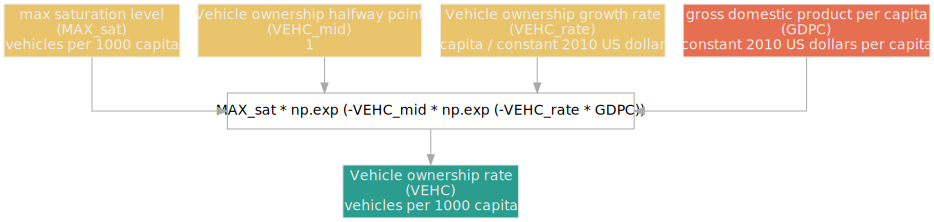

In [155]:
model.draw()

In [165]:
res = model.run(data_dict)

In [156]:
scores = score_model(model, data_dict)

In [157]:
scores.keys()

dict_keys(['score_by_Variable', 'score_by_ISO', 'score_by_ISO_Variable'])

In [162]:
scores['score_by_ISO']

,r2,correlation,rmse
ISO,,,
ARG,0.365971,0.796601,925.656883
AUT,0.860679,0.942868,181.663873
BEL,0.957400,0.979879,35.264028
DEU,0.459773,0.706073,359.891094
FRA,0.906773,0.952628,54.372153
JPN,0.506497,0.712827,59.474629
KOR,0.940654,0.990346,48.709117
UZB,0.226237,0.983198,85.600585


In [163]:
scores['score_by_Variable']

,r2,correlation,rmse
Variable,,,
VEHC,0.989726,0.99487,195.572754
